<a href="https://colab.research.google.com/github/miltonguineto/500-AI-Agents-Projects/blob/main/C%C3%B3pia_de_IC_NeuroData_Classifica%C3%A7%C3%A3o_de_Tumores_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Objetivo
#Usar SVM (Support Vector Machine) para classificar imagens de ressonância magnética (MRI) entre duas classes:

# 0 = Healthy (sem tumor)
# 1 = Tumor
# Como o SVM não trabalha diretamente com imagens, precisamos extrair características ou achatar as imagens em vetores numéricos.

# Passo 1: Instalar e configurar a API do Kaggle

# Instalar o cliente Kaggle
!pip install kaggle --upgrade -q

# Importar módulo de upload do Colab
from google.colab import files

# Fazer upload do arquivo kaggle.json (suas credenciais)
print("Faça upload do arquivo kaggle.json da sua conta Kaggle.")
uploaded = files.upload()  # Clique em "Choose Files" e selecione kaggle.json

# Configurar credenciais
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Testar se a API está funcionando
!kaggle datasets list -s "brain tumor" | head -n 5

Faça upload do arquivo kaggle.json da sua conta Kaggle.


Saving kaggle.json to kaggle.json
ref                                                       title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jakeshbohaju/brain-tumor                                  Brain Tumor                                          14629270  2020-07-26 01:52:35.323000          24112        321  0.9411765        
masoudnickparvar/brain-tumor-mri-dataset                  Brain Tumor MRI Dataset                             155791278  2021-09-24 12:43:45.510000         145606       1001  0.875            
jillanisofttech/brain-tumor                               Brain Tumor                                            343231  2022-01-12 10:23:23.777000           4896         71  0.9705882        


In [ ]:
# Passo 2: Baixar e descompactar o dataset correto
# O dataset é este:
#👉 murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

# Baixar o dataset (como dataset, não competição!)
!kaggle datasets download -d murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

# Descompactar
!unzip -q brain-tumor-multimodal-image-ct-and-mri.zip

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 93% 335M/361M [00:01<00:00, 222MB/s]
100% 361M/361M [00:01<00:00, 251MB/s]


In [ ]:
# Passo 3: Verificar a estrutura real das pastas
# Verificar como os arquivos estão organizados:

import os

for root, dirs, files in os.walk("/content"):
    level = root.replace("/content", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files[:3]:  # Mostrar só 3 arquivos por pasta
        print(f"{subindent}{f}")

content/
  kaggle.json
  brain-tumor-multimodal-image-ct-and-mri.zip
  .config/
    default_configs.db
    .last_survey_prompt.yaml
    .last_update_check.json
    logs/
      2025.10.03/
        13.35.25.672721.log
        13.36.16.394866.log
        13.35.53.232428.log
    configurations/
      config_default
  Dataset/
    Brain Tumor MRI images/
      MRI image source.txt
      Tumor/
        meningioma (520).jpg
        pituitary (465).jpg
        glioma (107).jpg
      Healthy/
        mri_healthy (694).jpg
        mri_healthy (1634).jpg
        mri_healthy (1747).jpg
    Brain Tumor CT scan Images/
      CT image source.txt
      Tumor/
        ct_tumor (1245).jpg
        ct_tumor (1949).jpg
        ct_tumor (322).jpg
      Healthy/
        ct_healthy (1561).jpg
        ct_healthy (209).png
        ct_healthy (360).png
  sample_data/
    anscombe.json
    README.md
    mnist_train_small.csv


In [ ]:
#  Importante: Esse dataset não tem a estrutura Healthy/ e Tumor/.
# Ele contém duas pastas principais:

# CT Images
# MRI Images
# E dentro de cada uma, há subpastas por classe:

# glioma
# meningioma
# notumor
# pituitary
# Então, se você quer um problema binário (tumor vs não tumor), podemos tratar:

# notumor → classe 0
# glioma, meningioma, pituitary → classe 1

In [ ]:
# Passo 4: Criar uma estrutura compatível com ImageFolder
# O torchvision.datasets.ImageFolder exige:

# dataset/
# ├── classe0/
# └── classe1/

# reorganizar os dados de MRI (ignorando CT por enquanto):

import os
import shutil
from pathlib import Path

# Criar nova estrutura
output_dir = Path("/content/brain_mri_binary")
output_dir.mkdir(exist_ok=True)

# Pastas de origem
mri_root = Path("/content/Dataset/Brain Tumor MRI images")

# Classes originais
tumor_classes = ["glioma", "meningioma", "pituitary"]
healthy_class = "notumor"

# Criar pastas de destino
(Path(output_dir) / "0_Healthy").mkdir(exist_ok=True)
(Path(output_dir) / "1_Tumor").mkdir(exist_ok=True)

# Copiar imagens
for cls in tumor_classes:
    src = mri_root / cls
    if src.exists():
        for img in src.glob("*"):
            if img.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                shutil.copy(img, output_dir / "1_Tumor" / img.name)

src_healthy = mri_root / healthy_class
if src_healthy.exists():
    for img in src_healthy.glob("*"):
        if img.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            shutil.copy(img, output_dir / "0_Healthy" / img.name)

print("Estrutura reorganizada com sucesso!")
print("Contagem:")
!ls /content/brain_mri_binary/0_Healthy/ | wc -l
!ls /content/brain_mri_binary/1_Tumor/ | wc -l


Estrutura reorganizada com sucesso!
Contagem:
0
0


In [ ]:
# Passo 5: Carregar o dataset com PyTorch

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Transformações
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Carregar dataset
dataset = datasets.ImageFolder(
    root="/content/brain_mri_binary",
    transform=transform
)

print("Classes mapeadas:", dataset.class_to_idx)
print("Total de imagens:", len(dataset))

Classes mapeadas: {'0_Healthy': 0, '1_Tumor': 1}
Total de imagens: 9618


In [ ]:
# Passo 6: Balancear e criar DataLoader

from torch.utils.data import DataLoader, Subset
import numpy as np

# Encontrar índices por classe
labels = [label for _, label in dataset]
class0_indices = [i for i, label in enumerate(labels) if label == 0]
class1_indices = [i for i, label in enumerate(labels) if label == 1]

print(f"Classe 0 (Healthy): {len(class0_indices)} imagens")
print(f"Classe 1 (Tumor): {len(class1_indices)} imagens")

# Balancear (pegar o mesmo número de cada classe)
n_samples = min(len(class0_indices), len(class1_indices), 1000)  # máximo 1000 por classe
balanced_indices = class0_indices[:n_samples] + class1_indices[:n_samples]

print(f"Usando {n_samples} imagens por classe = {2*n_samples} total")

# Criar subconjunto balanceado
balanced_dataset = Subset(dataset, balanced_indices)

# Criar DataLoader
MRI_dataloader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)

print(f"✅ Dataset balanceado criado: {len(balanced_dataset)} imagens")

Classe 0 (Healthy): 4300 imagens
Classe 1 (Tumor): 5318 imagens
Usando 1000 imagens por classe = 2000 total
✅ Dataset balanceado criado: 2000 imagens


In [ ]:
# Passo 7: Converter para NumPy (pronto para SVM)

import numpy as np

print("Convertendo imagens para formato NumPy...")

X = []  # Features (imagens achatadas)
y = []  # Labels

for batch_idx, (images, labels) in enumerate(MRI_dataloader):
    # Achatar as imagens: (batch_size, 3, 224, 224) → (batch_size, 3*224*224)
    X.append(images.view(images.size(0), -1).numpy())
    y.append(labels.numpy())

    if batch_idx % 10 == 0:
        print(f"Processado batch {batch_idx+1}/{len(MRI_dataloader)}")

# Concatenar todos os batches
X = np.vstack(X)  # Shape: (2*n_samples, 150528)
y = np.concatenate(y)

print(f"✅ Conversão concluída!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Distribuição de classes: {np.bincount(y)}")
print(f"Tipo de dados: {X.dtype}")

Convertendo imagens para formato NumPy...
Processado batch 1/63
Processado batch 11/63
Processado batch 21/63
Processado batch 31/63
Processado batch 41/63
Processado batch 51/63
Processado batch 61/63
✅ Conversão concluída!
X shape: (2000, 150528)
y shape: (2000,)
Distribuição de classes: [1000 1000]
Tipo de dados: float32


In [ ]:
# Passo 8: Treinar SVM com scikit-learn
# Agora vamos usar diferentes tipos de SVM:

# Opção A: LinearSVC (mais rápido para alta dimensionalidade)

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import time

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

# Normalizar os dados (OBRIGATÓRIO para SVM!)
print("Normalizando dados...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar LinearSVC
print("Treinando LinearSVM...")
start_time = time.time()

linear_svm = LinearSVC(
    C=1.0,
    max_iter=5000,
    random_state=42,
    dual=False  # Recomendado quando n_samples > n_features
)

linear_svm.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Avaliar
train_acc = linear_svm.score(X_train_scaled, y_train)
test_acc = linear_svm.score(X_test_scaled, y_test)

print(f"✅ Treinamento concluído em {training_time:.2f} segundos")
print(f"Acurácia no treino: {train_acc:.4f}")
print(f"Acurácia no teste: {test_acc:.4f}")

# Relatório detalhado
y_pred = linear_svm.predict(X_test_scaled)
print("\n📊 Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Tumor']))

Treino: 1600 amostras
Teste: 400 amostras
Normalizando dados...
Treinando LinearSVM...
✅ Treinamento concluído em 55.78 segundos
Acurácia no treino: 1.0000
Acurácia no teste: 0.9275

📊 Relatório de classificação:
              precision    recall  f1-score   support

     Healthy       0.89      0.98      0.93       200
       Tumor       0.98      0.88      0.92       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
# Opção B: SVM com kernel RBF (pode ser mais lento)

from sklearn.svm import SVC

# Usar apenas uma amostra menor para RBF (devido à complexidade)
n_subset = min(1000, len(X_train))  # Máximo 1000 para treino
indices = np.random.choice(len(X_train), n_subset, replace=False)

X_train_subset = X_train_scaled[indices]
y_train_subset = y_train[indices]

print(f"Usando subset de {n_subset} amostras para SVM RBF...")

# Treinar SVM RBF
start_time = time.time()
rbf_svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

rbf_svm.fit(X_train_subset, y_train_subset)
training_time = time.time() - start_time

# Avaliar
test_acc_rbf = rbf_svm.score(X_test_scaled, y_test)

print(f"✅ SVM RBF treinado em {training_time:.2f} segundos")
print(f"Acurácia no teste (RBF): {test_acc_rbf:.4f}")

Usando subset de 1000 amostras para SVM RBF...
✅ SVM RBF treinado em 117.69 segundos
Acurácia no teste (RBF): 0.9050


In [ ]:
# Passo 9: Comparar resultados

print("🏆 COMPARAÇÃO DE RESULTADOS:")
print("="*50)
print(f"LinearSVM - Acurácia: {test_acc:.4f}")
if 'test_acc_rbf' in locals():
    print(f"RBF SVM   - Acurácia: {test_acc_rbf:.4f}")
print("="*50)

🏆 COMPARAÇÃO DE RESULTADOS:
LinearSVM - Acurácia: 0.9275
RBF SVM   - Acurácia: 0.9050


/tmp/ipython-input-982789060.py:66: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-982789060.py:66: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


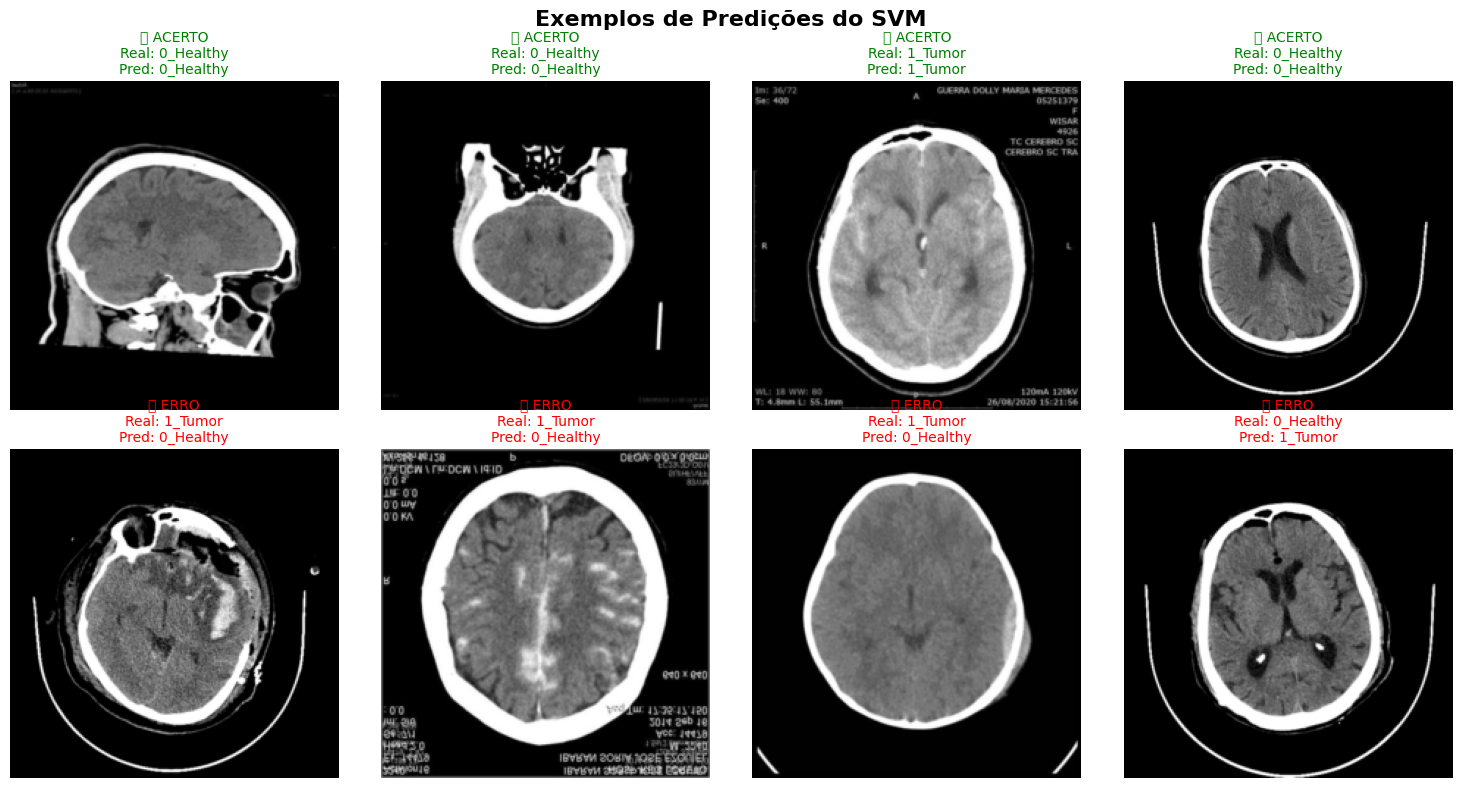

In [ ]:
# plus: Predições com várias opções que mostram imagens reais das análises do SVM

# Opção 1: Mostrar exemplos de acertos e erros

import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, X_test_scaled, y_test, dataset, test_indices, n_examples=8):
    """
    Visualiza exemplos de predições do SVM com as imagens originais
    """
    # Fazer predições
    y_pred = model.predict(X_test_scaled)

    # Encontrar índices de acertos e erros
    correct_indices = np.where(y_pred == y_test)[0]
    wrong_indices = np.where(y_pred != y_test)[0]

    # Selecionar exemplos
    n_correct = min(n_examples//2, len(correct_indices))
    n_wrong = min(n_examples//2, len(wrong_indices))

    selected_correct = np.random.choice(correct_indices, n_correct, replace=False)
    selected_wrong = np.random.choice(wrong_indices, n_wrong, replace=False) if len(wrong_indices) > 0 else []

    # Criar figura
    fig, axes = plt.subplots(2, max(n_correct, len(selected_wrong)), figsize=(15, 8))
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)

    # Plotar acertos
    for i, idx in enumerate(selected_correct):
        original_idx = test_indices[idx]  # Índice original no dataset
        img, true_label = dataset[original_idx]
        pred_label = y_pred[idx]

        # Converter tensor para numpy e ajustar dimensões
        img_np = img.permute(1, 2, 0).numpy()

        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f'✅ ACERTO\nReal: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}',
                           color='green', fontsize=10)
        axes[0, i].axis('off')

    # Plotar erros (se houver)
    for i, idx in enumerate(selected_wrong):
        original_idx = test_indices[idx]
        img, true_label = dataset[original_idx]
        pred_label = y_pred[idx]

        img_np = img.permute(1, 2, 0).numpy()

        axes[1, i].imshow(img_np)
        axes[1, i].set_title(f'❌ ERRO\nReal: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_label]}',
                           color='red', fontsize=10)
        axes[1, i].axis('off')

    # Remover eixos vazios
    for i in range(max(n_correct, len(selected_wrong))):
        if i >= n_correct:
            axes[0, i].axis('off')
        if i >= len(selected_wrong):
            axes[1, i].axis('off')

    plt.suptitle('Exemplos de Predições do SVM', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Precisamos dos índices originais do dataset para esta função
# Vamos reconstruir os índices de teste
from sklearn.model_selection import train_test_split

# Obter índices originais do balanced_dataset
original_indices = balanced_dataset.indices

# Dividir os índices da mesma forma que dividimos X e y
train_indices, test_indices = train_test_split(
    original_indices, test_size=0.2, random_state=42,
    stratify=[dataset[i][1] for i in original_indices]
)

# Agora visualizar (assumindo que você já treinou um modelo)
if 'best_linear_svm' in locals():
    visualize_predictions(best_linear_svm, X_test_scaled, y_test, dataset, test_indices)
elif 'linear_svm' in locals():
    visualize_predictions(linear_svm, X_test_scaled, y_test, dataset, test_indices)

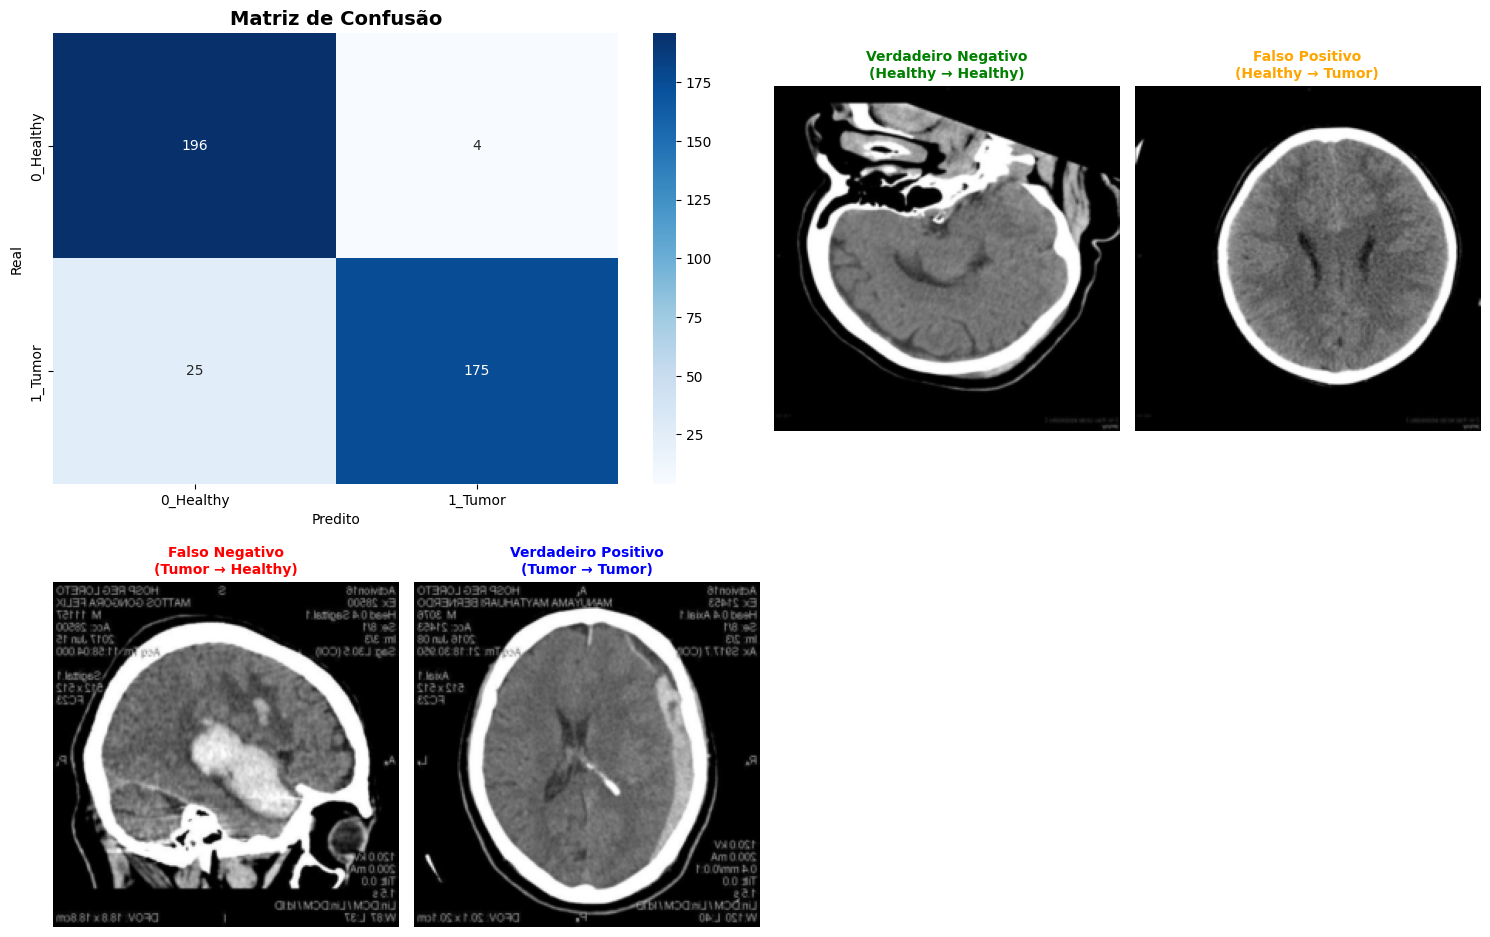

📊 Estatísticas da Matriz de Confusão:
Verdadeiros Negativos (TN): 196
Falsos Positivos (FP): 4
Falsos Negativos (FN): 25
Verdadeiros Positivos (TP): 175

📈 Métricas:
Acurácia: 0.9275
Precisão: 0.9777
Recall: 0.8750


In [ ]:
# Opção 2: Matriz de Confusão com exemplos

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_with_examples(model, X_test_scaled, y_test, dataset, test_indices):
    """
    Plota matriz de confusão e exemplos de cada categoria
    """
    # Predições
    y_pred = model.predict(X_test_scaled)

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Criar figura com subplots
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Matriz de confusão
    plt.subplot(2, 4, (1, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
    plt.ylabel('Real')
    plt.xlabel('Predito')

    # Encontrar exemplos para cada categoria da matriz de confusão
    categories = {
        'TN': np.where((y_test == 0) & (y_pred == 0))[0],  # True Negative
        'FP': np.where((y_test == 0) & (y_pred == 1))[0],  # False Positive
        'FN': np.where((y_test == 1) & (y_pred == 0))[0],  # False Negative
        'TP': np.where((y_test == 1) & (y_pred == 1))[0],  # True Positive
    }

    titles = {
        'TN': 'Verdadeiro Negativo\n(Healthy → Healthy)',
        'FP': 'Falso Positivo\n(Healthy → Tumor)',
        'FN': 'Falso Negativo\n(Tumor → Healthy)',
        'TP': 'Verdadeiro Positivo\n(Tumor → Tumor)'
    }

    colors = {'TN': 'green', 'FP': 'orange', 'FN': 'red', 'TP': 'blue'}

    # Plotar um exemplo de cada categoria
    for i, (cat, indices) in enumerate(categories.items(), 3):
        plt.subplot(2, 4, i)

        if len(indices) > 0:
            # Pegar um exemplo aleatório
            idx = np.random.choice(indices)
            original_idx = test_indices[idx]
            img, true_label = dataset[original_idx]

            # Mostrar imagem
            img_np = img.permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            plt.title(titles[cat], color=colors[cat], fontsize=10, fontweight='bold')
            plt.axis('off')
        else:
            plt.text(0.5, 0.5, f'Nenhum exemplo\nde {cat}',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(titles[cat], color=colors[cat], fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Estatísticas
    print("📊 Estatísticas da Matriz de Confusão:")
    print(f"Verdadeiros Negativos (TN): {cm[0,0]}")
    print(f"Falsos Positivos (FP): {cm[0,1]}")
    print(f"Falsos Negativos (FN): {cm[1,0]}")
    print(f"Verdadeiros Positivos (TP): {cm[1,1]}")

    # Métricas
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0

    print(f"\n📈 Métricas:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

# Executar
if 'best_linear_svm' in locals():
    plot_confusion_matrix_with_examples(best_linear_svm, X_test_scaled, y_test, dataset, test_indices)
elif 'linear_svm' in locals():
    plot_confusion_matrix_with_examples(linear_svm, X_test_scaled, y_test, dataset, test_indices)

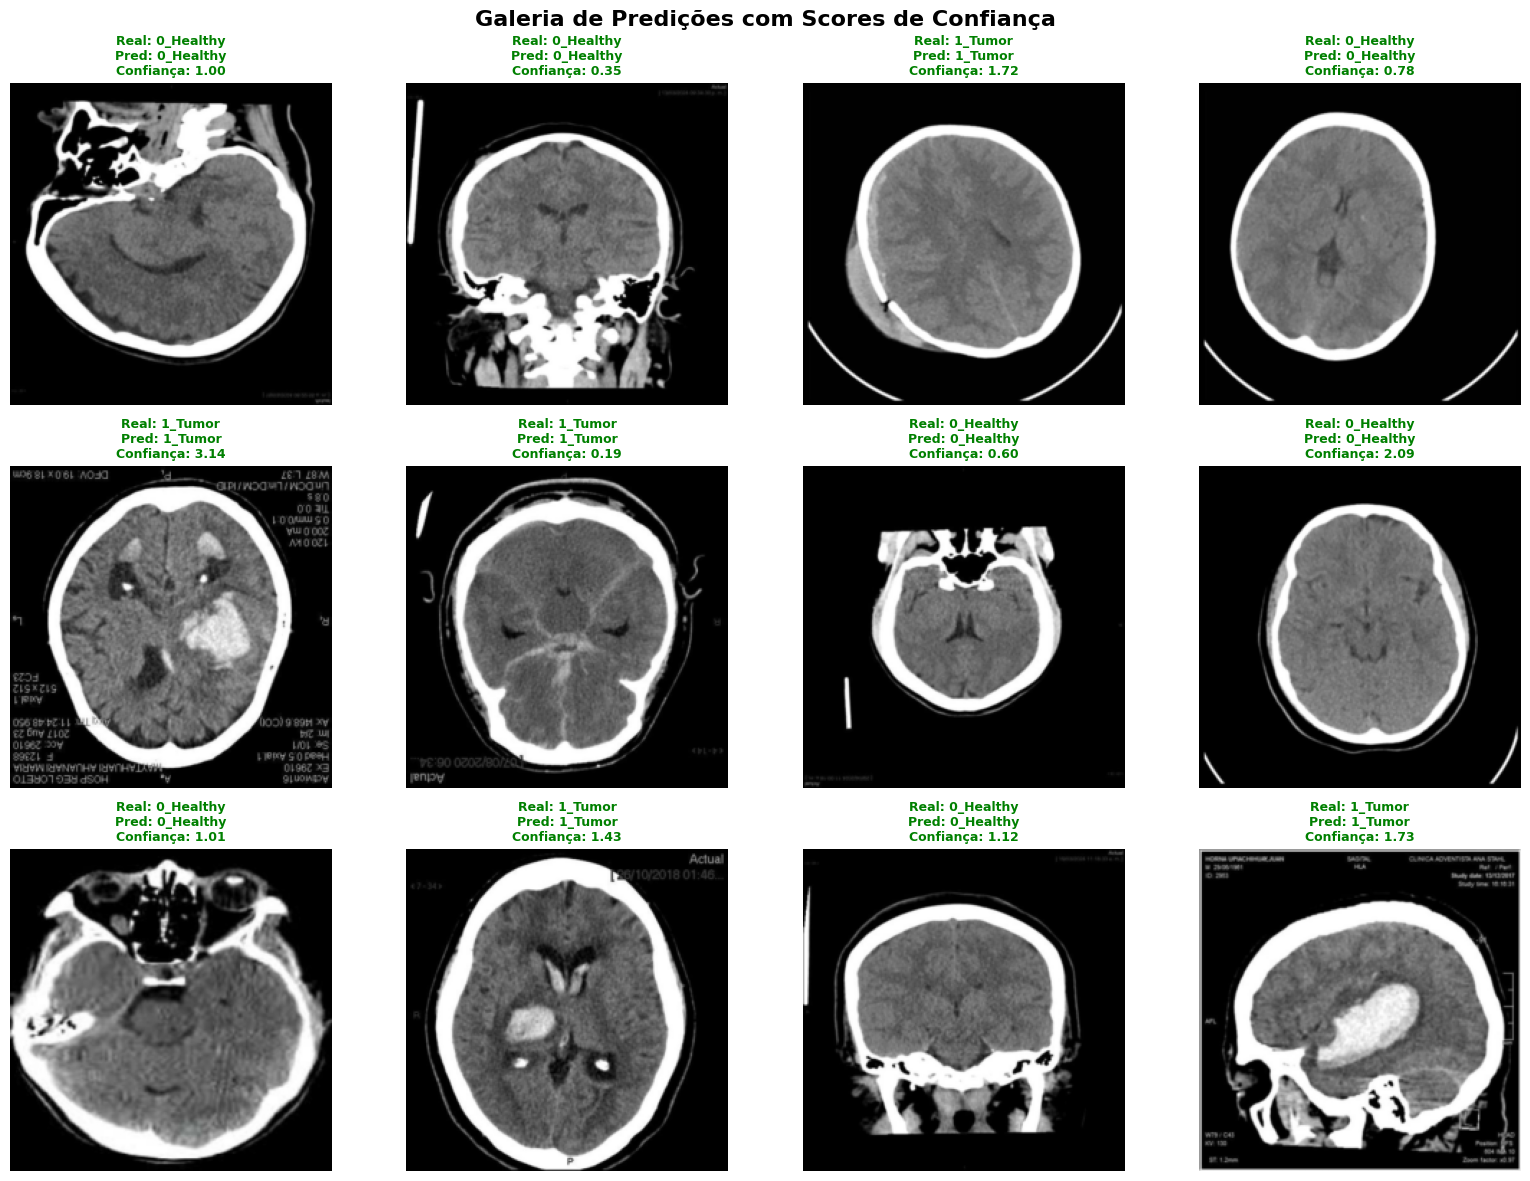

In [ ]:
# Opção 3: Galeria de predições com confiança

def plot_prediction_gallery(model, X_test_scaled, y_test, dataset, test_indices, n_images=12):
    """
    Mostra uma galeria de predições com diferentes níveis de confiança
    """
    # Se o modelo suporta probabilidades
    if hasattr(model, 'decision_function'):
        confidence_scores = model.decision_function(X_test_scaled)
        y_pred = model.predict(X_test_scaled)
    else:
        print("Modelo não suporta scores de confiança")
        return

    # Criar figura
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    # Selecionar exemplos diversos
    indices = np.random.choice(len(y_test), n_images, replace=False)

    for i, idx in enumerate(indices):
        original_idx = test_indices[idx]
        img, true_label = dataset[original_idx]
        pred_label = y_pred[idx]
        confidence = abs(confidence_scores[idx])

        # Converter imagem
        img_np = img.permute(1, 2, 0).numpy()

        # Determinar cor baseada no acerto/erro
        color = 'green' if pred_label == true_label else 'red'

        # Plotar
        axes[i].imshow(img_np)
        axes[i].set_title(
            f'Real: {dataset.classes[true_label]}\n'
            f'Pred: {dataset.classes[pred_label]}\n'
            f'Confiança: {confidence:.2f}',
            color=color, fontsize=9, fontweight='bold'
        )
        axes[i].axis('off')

    plt.suptitle('Galeria de Predições com Scores de Confiança', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Executar
if 'best_linear_svm' in locals():
    plot_prediction_gallery(best_linear_svm, X_test_scaled, y_test, dataset, test_indices)
elif 'linear_svm' in locals():
    plot_prediction_gallery(linear_svm, X_test_scaled, y_test, dataset, test_indices)

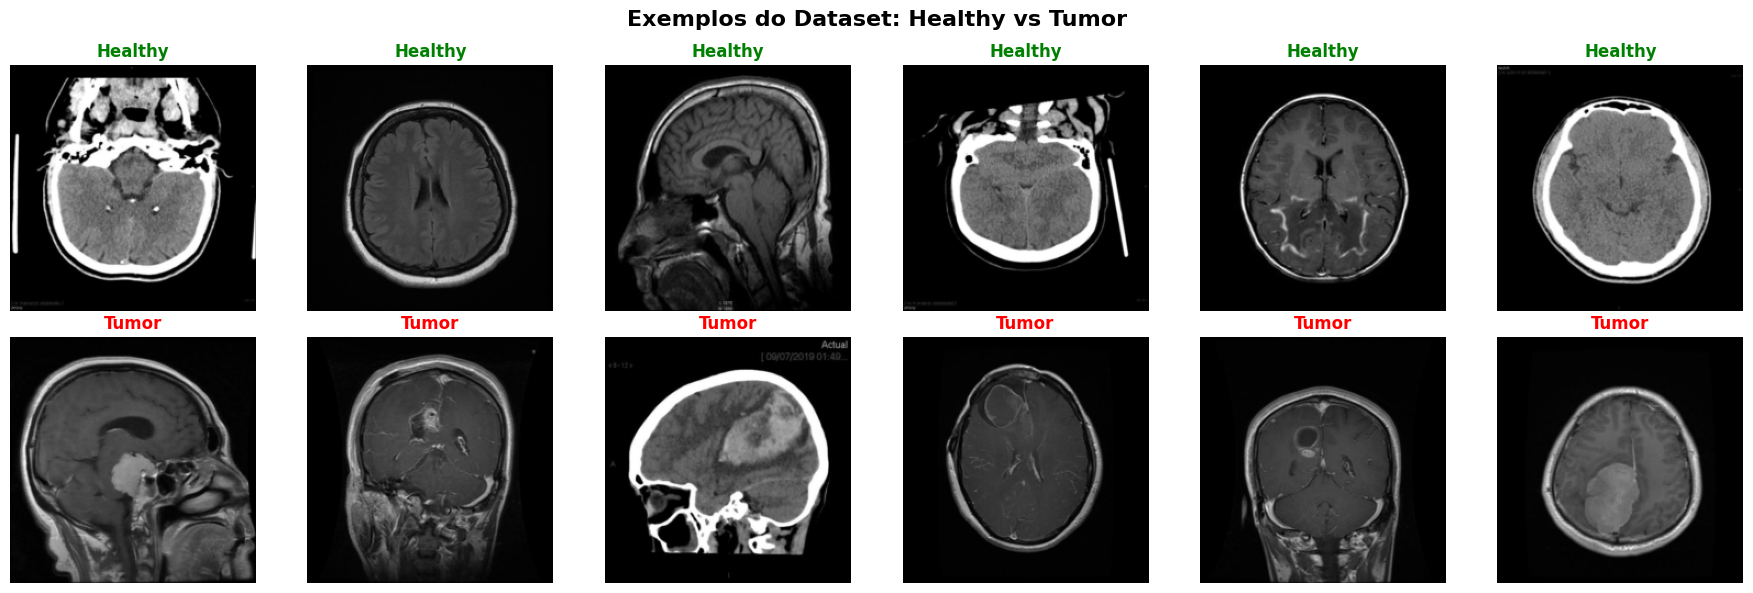

In [ ]:
# Comparação lado a lado: Healthy vs Tumor

def show_class_examples(dataset, n_examples=6):
    """
    Mostra exemplos de cada classe lado a lado
    """
    # Encontrar exemplos de cada classe
    healthy_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
    tumor_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

    # Selecionar exemplos aleatórios
    selected_healthy = np.random.choice(healthy_indices, n_examples, replace=False)
    selected_tumor = np.random.choice(tumor_indices, n_examples, replace=False)

    # Criar figura
    fig, axes = plt.subplots(2, n_examples, figsize=(18, 6))

    # Plotar exemplos saudáveis
    for i, idx in enumerate(selected_healthy):
        img, _ = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_np)
        axes[0, i].set_title('Healthy', color='green', fontweight='bold')
        axes[0, i].axis('off')

    # Plotar exemplos com tumor
    for i, idx in enumerate(selected_tumor):
        img, _ = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()
        axes[1, i].imshow(img_np)
        axes[1, i].set_title('Tumor', color='red', fontweight='bold')
        axes[1, i].axis('off')

    plt.suptitle('Exemplos do Dataset: Healthy vs Tumor', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Mostrar exemplos do dataset
show_class_examples(dataset)